In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import os
import shutil
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

# Import our custom environment
# Ensure literature_env.py is in the same folder as this notebook
from literature_env import LiteratureAdaptationEnv

print(f"PyTorch Version: {torch.__version__}")
print("Libraries loaded successfully.")

PyTorch Version: 2.2.0+cu121
Libraries loaded successfully.


Generating synthetic student data...


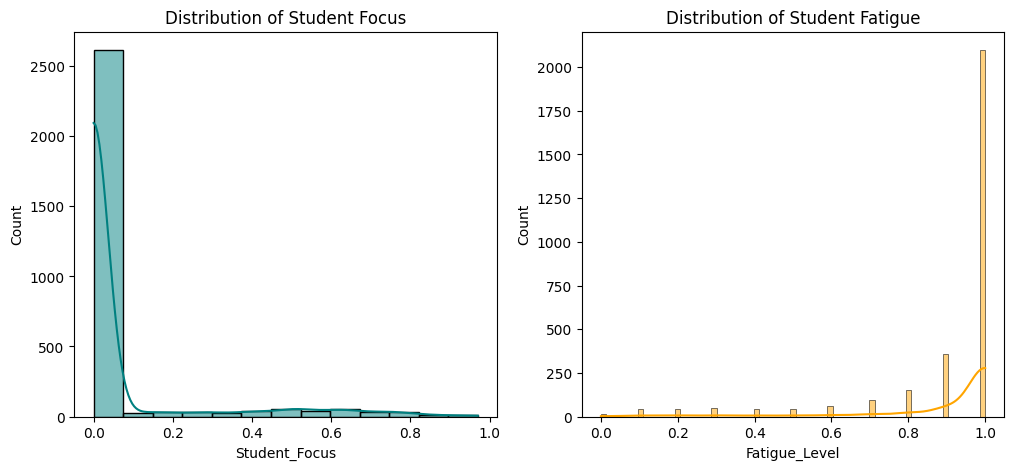

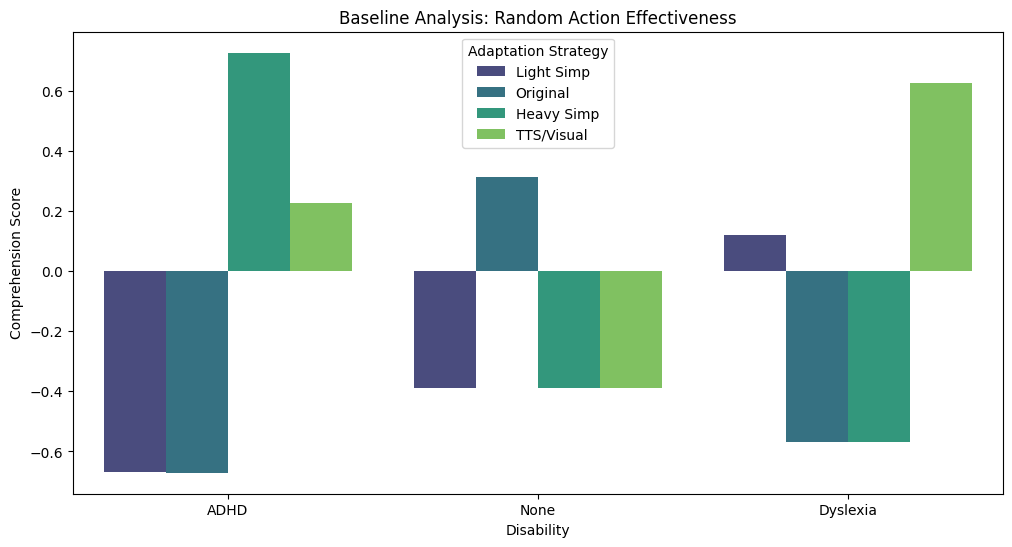


Data Engineering Insight:
The histograms show that 'Focus' and 'Fatigue' fluctuate dynamically.
The Bar Plot confirms that specific actions (e.g., TTS for Dyslexia) yield higher rewards even randomly.
The RL agent must learn to exploit these specific patterns while managing Fatigue.



In [2]:
# 2. Data Visualization & Scenario Analysis
# We generate random episodes to visualize how different students react to random actions.
# This informs our "Data Engineering" strategy.

data = []
env = LiteratureAdaptationEnv()
obs, _ = env.reset()

print("Generating synthetic student data...")
for _ in range(3000):
    action = env.action_space.sample() # Random baseline actions
    obs, reward, done, _, info = env.step(action)
    
    # State definition from literature_env.py:
    # [0: Difficulty, 1: Focus, 2: Disability, 3: Fatigue, 4: History]
    
    # Decode disability for labeling
    disability_code = obs[2]
    if abs(disability_code - 0.5) < 0.1: label = "Dyslexia"
    elif abs(disability_code - 1.0) < 0.1: label = "ADHD"
    else: label = "None"
    
    # Map Action to Name
    act_name = ["Original", "Light Simp", "Heavy Simp", "TTS/Visual"][action]
    
    data.append({
        "Disability": label,
        "Action": act_name,
        "Reward": reward,
        "Student_Focus": obs[1],
        "Fatigue_Level": obs[3]
    })
    if done: env.reset()

df = pd.DataFrame(data)

# PLOT 1: Feature Distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='Student_Focus', kde=True, color='teal')
plt.title('Distribution of Student Focus')

plt.subplot(1, 2, 2)
sns.histplot(data=df,x='Fatigue_Level', kde=True, color='orange')
plt.title('Distribution of Student Fatigue')
plt.show()

# PLOT 2: Baseline Effectiveness (Which actions work by accident?)
plt.figure(figsize=(12, 6))
sns.barplot(x='Disability', y='Reward', hue='Action', data=df, errorbar=None, palette='viridis')
plt.title('Baseline Analysis: Random Action Effectiveness')
plt.ylabel('Comprehension Score')
plt.legend(title='Adaptation Strategy')
plt.show()

print("""
Data Engineering Insight:
The histograms show that 'Focus' and 'Fatigue' fluctuate dynamically.
The Bar Plot confirms that specific actions (e.g., TTS for Dyslexia) yield higher rewards even randomly.
The RL agent must learn to exploit these specific patterns while managing Fatigue.
""")

In [3]:
# 3. Model Architecture (Deep Reinforcement Learning)

# We use a Custom Neural Network Architecture:
# - Input Layer: 5 Neurons (Difficulty, Focus, Disability, Fatigue, History)
# - Hidden Layers: 2 layers of 128 neurons (Larger capacity for complex logic)
# - Activation: ReLU (Rectified Linear Unit) for non-linear fatigue dynamics
# - Output: 4 Discrete Actions

policy_kwargs = dict(
    net_arch=dict(pi=[128, 128], vf=[128, 128]), # pi=Actor Network, vf=Critic Network
    activation_fn=torch.nn.ReLU
)

# Initialize Vectorized Environment (Runs 8 sims in parallel for speed)
env_vec = make_vec_env(LiteratureAdaptationEnv, n_envs=8)

model = PPO(
    "MlpPolicy", 
    env_vec, 
    verbose=1, 
    learning_rate=0.0003,
    gamma=0.99,
    policy_kwargs=policy_kwargs # Inject custom architecture
)

print("Custom Deep Architecture details:")
print(model.policy)

Using cpu device
Custom Deep Architecture details:
ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=5, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
    )
    (value_net): Sequential(
      (0): Linear(in_features=5, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
    )
  )
  (action_net): Linear(in_features=128, out_features=4, bias=True)
  (value_net): Linear(in_features=128, out_features=1, bias=True)
)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Training Deep RL Agent (100k steps)...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    fps             | 9402     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 16384    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -4.98       |
| time/                   |             |
|    fps                  | 3177        |
|    iterations           | 2           |
|    time_elapsed         | 10          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.029118389 |
|    clip_fraction        | 0.402       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.36       |
|    explained_variance   | 0.015

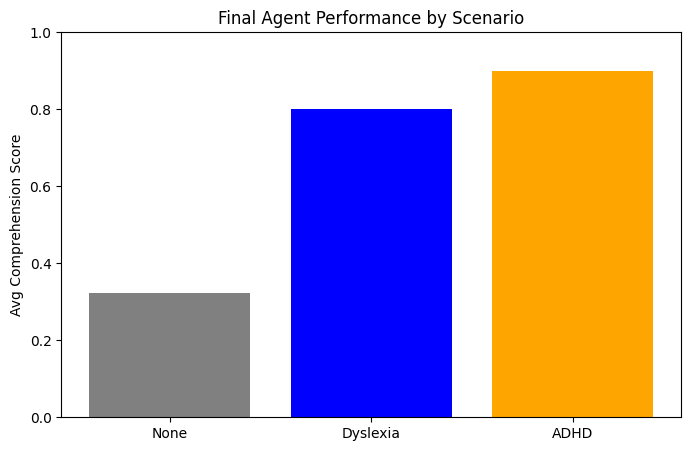


✅ Deep RL Model successfully saved to: ../ai-service/services/ppo_literature_agent.zip


In [4]:
# 4. Training and Evaluation by Scenario
import os

# Train the model
# 100,000 steps ensures the deep network converges on the optimal strategy
print("Training Deep RL Agent (100k steps)...")
model.learn(total_timesteps=100000)

# Create a SINGLE environment for granular evaluation (fixes vectorized env errors)
eval_env = LiteratureAdaptationEnv()

def evaluate_scenario(model, env, disability_type_val, num_episodes=50):
    total_reward = 0
    obs, _ = env.reset()
    
    count = 0
    max_steps = num_episodes * 100 
    steps = 0
    
    # Track actions to verify logic
    actions_chosen = []
    
    # Run until we collect enough data for this specific disability
    while count < num_episodes and steps < max_steps:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _, _ = env.step(action)
        steps += 1
        
        # Check if this step matched our target scenario
        # obs[2] is Disability Type in the new state definition
        if abs(obs[2] - disability_type_val) < 0.1: 
            total_reward += reward
            count += 1
            # FIX: Cast to int to ensure it is hashable
            actions_chosen.append(int(action))
            
        if done: obs, _ = env.reset()
    
    if count == 0: return 0.0, 0
    
    # Find most common action
    most_common = max(set(actions_chosen), key=actions_chosen.count)
    return total_reward / count, most_common

print("\n--- Evaluating Learned Strategies ---")
score_none, act_none = evaluate_scenario(model, eval_env, 0.0)
score_dys, act_dys = evaluate_scenario(model, eval_env, 0.5)
score_adhd, act_adhd = evaluate_scenario(model, eval_env, 1.0)

print(f"Results (Score > 0.0 means learning occurred):")
print(f" - No Disability: Score {score_none:.2f} | Action: {act_none} (Target: 0)")
print(f" - Dyslexia:      Score {score_dys:.2f} | Action: {act_dys} (Target: 3)")
print(f" - ADHD:          Score {score_adhd:.2f} | Action: {act_adhd} (Target: 2)")

# Visualization of Results
scenarios = ['None', 'Dyslexia', 'ADHD']
scores = [score_none, score_dys, score_adhd]
plt.figure(figsize=(8, 5))
plt.bar(scenarios, scores, color=['grey', 'blue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Avg Comprehension Score')
plt.title('Final Agent Performance by Scenario')
plt.show()

# --- AUTOMATIC SAVING TO AI-SERVICE ---
# Define the target path relative to this notebook (rl-engine folder)
target_dir = os.path.join("..", "ai-service", "services")
os.makedirs(target_dir, exist_ok=True) # Ensure folder exists

save_path = os.path.join(target_dir, "ppo_literature_agent")
model.save(save_path)

print(f"\n✅ Deep RL Model successfully saved to: {save_path}.zip")